# **Markowitz portfolio multi-objective optimization**

***markowitz_multiojb.ipynb***

Markowitz portfolio optimization. A multi-objective quadratic programming example.

In Markowitz portfolio optimization there are two objectives: to maximize reward while minimizing risk (i.e. variance). This example plots several points on the optimal frontier using a blended multi-objective approach, and shows that a point computed using a lexicographic approach also lies on this frontier.

&copy; Copyright 2025-2026 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://www.fico.com/en/shrinkwrap-license-agreement-fico-xpress-optimization-suite-on-premises) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

In [ ]:
# Install the necessary packages
%pip install -q xpress matplotlib

## Problem description

Markowitz portfolio optimization focuses on making a selection on the fraction of a budget to allocate to $S$ possible stocks to form a portfolio with two key objectives:

  - Maximize expected returns: $\max \sum_{i \in \mathcal{S}} RET_i \cdot frac_i$
  - Minimize the portfolio variance: $\min \sum_{i,j \in \mathcal{S}} frac_i \cdot frac_j \cdot COV_{i,j}$ 
  
where:

  - $frac$ is the vector of portfolio stock allocations.
  - $COV$ is the covariance matrix of asset returns.
  - $RET$ is the returns vector.

The sum of the portfolio stock allocations should be equal to 1 (fully invested portfolio): $\sum_{i \in \mathcal{S}} frac_i = 1$

In this example, we work with $S$ = 5 stocks, where the matrix of co-variance between each pair of stocks is given by:

|   | Stock 1 | Stock 2 | Stock 3 | Stock 4 | Stock 5 |
|---|---|---|---|---|---|
| **Stock 1** | 0.32 | 0.70 | 0.19 | 0.52 | 0.16 |
| **Stock 2** | 0.70 | 4.35 | -0.48 | -0.06 | -0.03 |
| **Stock 3** | 0.19 | -0.48 | 0.98 | 1.10 | 0.10 |
| **Stock 4** | 0.52 | -0.60 | 1.10 | 2.48 | 0.37 |
| **Stock 5** | 0.16 | -0.30 | 0.10 | 0.37 | 0.31 |

The returns of each stock are given as:

|   | Returns |
|---|---|
| **Stock 1** | 0.31 |
| **Stock 2** | 0.87 |
| **Stock 3** | 0.31 |
| **Stock 4** | 0.66 |
| **Stock 5** | 0.24 |

## Data preparation

The necessary packages are imported, and returns and covariance data is created as NumPy arrays to allow the use of the [xpress.Dot()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/xpress.Dot.html) operator.

In [1]:
import xpress as xp
import numpy as np
from matplotlib import pyplot as plt

# The historical mean return on investment for five stocks
RET = np.array([0.31, 0.87, 0.31, 0.66, 0.24])

# The historical covariances of the five stocks
COV = np.array([
  [0.32,  0.70,  0.19,  0.52,  0.16],
  [0.70,  4.35, -0.48, -0.06, -0.03],
  [0.19, -0.48,  0.98,  1.10,  0.10],
  [0.52, -0.6,   1.10,  2.48,  0.37],
  [0.16, -0.3,   0.10,  0.37,  0.31]
])

## Model implementation and visualization of efficient frontier

Non-negative variables represent percentage of capital to invest in each stock. In order to use Xpress' built in multi-objective handling functionality, all objectives must be linear, so we define a free variable *variance* to serve as transfer variable.

A list of constraints is created and passed as an argument to [problem.addConstraint()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addConstraint.html).

In [2]:
p = xp.problem()

# Non-negative variables represent percentage of capital to invest in each stock
frac = p.addVariables(len(RET))

# All objectives must be linear, so we define a free variable for the variance
variance = p.addVariable(lb=-xp.infinity)

ctrs = [
  xp.Sum(frac) == 1,                             # Must invest 100% of capital
  xp.Dot(frac, COV, frac) - variance <= 0    # Set up transfer variable for variance
]

p.addConstraint(ctrs)

Next we define the two objectives. First, we call [problem.setObjective()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.setObjective.html) to define the first objective, and the second objective is added using the [problem.addObjective()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addObjective.html) method, which is designed for the formulation of multi-objective optimization problems by adding a new objective to an optimization problem.

Alternatively, the [problem.setObjective()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.setObjective.html) method can be used to add a new objective to a problem, as long as an *objidx* argument is defined for each objective, as consecutive integers starting from zero.

In [3]:
p.setObjective(xp.Dot(frac, RET))     # Maximize mean return
p.addObjective(variance)              # Minimize variance

# or alternatively
#p.setObjective(xp.Dot(frac, ret), objidx=0)
#p.setObjective(variance, objidx=1)

Vary the objective weights to explore the optimal frontier, with the first objective having a weight ranging from 0.05 up to 0.95, with the second objective (weight) being the complement for each instance.

A loop allows iterating through each of the 100 weight cases, optimize and save the two objective values in each instance (coordinates).

When using either [problem.setObjective()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.setObjective.html) or [problem.addObjective()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addObjective.html), if **objectives have equal priority but different weights, a Blended (or Archimedian) approach is applied**, setting as objective function of the problem the linear combination of the added objectives and their weights.

In [ ]:
# Vary the objective weights to explore the optimal frontier
weights = np.linspace(0.05, 0.95, 100)
means = []
variances = []

for w in weights:
  p.setObjective(objidx=0, weight=w,sense=xp.maximize)  # First objective defines the sense of the problem
  p.setObjective(objidx=1, weight=w-1)                  # Reverse the sense by assigning a negative weight because we minimize variance
  p.optimize()
  means.append(xp.Dot(p.getSolution(frac), RET).item())
  variances.append(p.getSolution(variance))

Draw an efficient frontier using the 20 points with *matplotlib*.

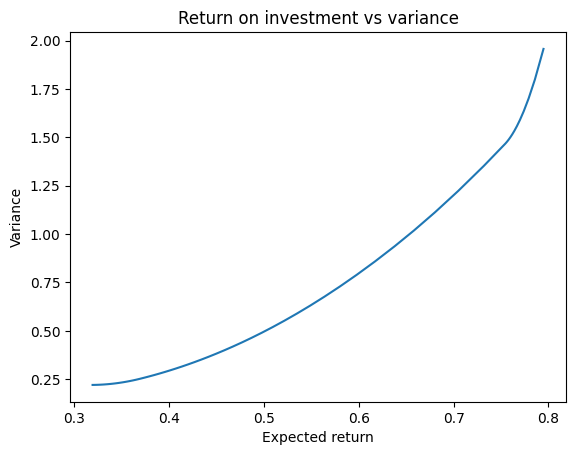

In [5]:
plt.plot(means, variances)
plt.title('Return on investment vs variance')
plt.xlabel('Expected return')
plt.ylabel('Variance')

plt.show()

## Applying a lexicographic approach

Now we will maximize profit alone, and then minimize variance while not sacrificing more than 10% of the maximum profit possible.

When **objectives have a different priority but the same weight, a Lexicographic approach is applied**. Xpress will solve the problem once for each distinct objective priority that is defined. All objectives from previous iterations are fixed to their optimal values within the tolerances:
  - For minimization objectives: <tt>objective <= optimal_value * (1 + reltol) + abstol</tt>
  - For maximization objectives: <tt>objective <= optimal_value * (1 - reltol) - abstol</tt>

with the parameter <tt>reltol</tt> being the relative tolerance and <tt>abstol</tt> the absolute tolerance for the objective in subsequent runs.

Further calls to [problem.setObjective()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.setObjective.html) allow users to configure each objective via the <tt>objidx</tt> argument, which receives the <tt>id</tt> of each objective, a counter starting with 0 in the order objectives are created. 

By running the code cell below, we can observe that the final soluton from the lexicographic method falls within the efficient frontier previously generated.

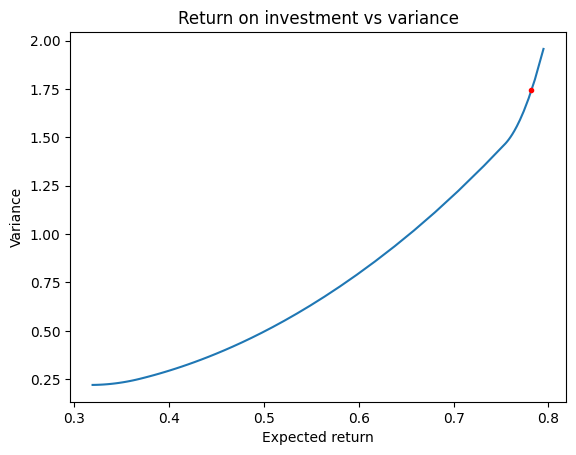

In [7]:
# Now we will maximize profit alone, and then minimize variance while not
# sacrificing more than 10% of the maximum profit
p.setObjective(objidx=0, priority=1, weight=1, reltol=0.1,sense=xp.maximize)
p.setObjective(objidx=1, priority=0, weight=-1)
p.controls.outputlog = 0 # Turn off output log for cleaner output
p.optimize()
m0 = xp.Dot(p.getSolution(frac), RET).item()
v0 = p.getSolution(variance)

plt.plot(means, variances)
plt.plot(m0, v0, c='r', marker='.')
plt.title('Return on investment vs variance')
plt.xlabel('Expected return')
plt.ylabel('Variance')
plt.show()